In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import ee
import io
import PyIF
import tqdm
import json
import fiona
import datetime
import requests
import urllib.request

import numpy as np
import xarray as xr
import pandas as pd
import rsfuncs as rs
import rasterio as rio
import geopandas as gp
import seaborn as sns
import multiprocessing as mp

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from sklearn import metrics
from scipy import stats, spatial
from affine import Affine
from datetime import timedelta
from rasterio import features, mask
from climata.usgs import DailyValueIO
from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

ee.Initialize()

%load_ext autoreload
%autoreload 2

/anaconda3/envs/pysheds/lib/python3.8/site-packages/numba/core/decorators.py:232: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


# The math


#### Entropy: 

Given a discrete random variable $X$, with possible outcomes $ x_{1},...,x_{n} $ which occur with probability $  \mathrm {P} (x_{1}),...,\mathrm {P} (x_{n}) $ the entropy (units of nats) of $X$ is defined as: <br>

$ H(X) =  - \sum_{i=1}^{n} P(x) \ln P(x) $

#### Joint Entropy:
of two discrete random variables $X$ and $Y$ is defined as the entropy of the joint distribution of $X$ and $Y$:

$ H(X,Y) =  - \sum_{i=1}^{n} P(x,y) \ln P(x,y) $


#### Conditional Entropy: 

The amount of information needed to describe the outcome of a random variable $Y$ given that the value of another random variable $X$ is known. Here, information is measured in shannons, nats, or hartleys. The entropy of $Y$ conditioned on $X$ is:

$ H (Y|X) = -\sum p(x,y)\ln {\frac {p(x,y)}{p(x)}} $


#### Relative Entropy, aka K-L Divergence,

The Relative Entropy (aka K-L divergence, $ D_{\text{KL}}(P\parallel Q)$ ), which measures how one probability distribution $P(x)$ is different from a second $Q(x)$ is defined as:

$ D_{\text{KL}}(P\parallel Q)=\sum _{x\in {\mathcal {X}}}P(x)\ln \left({\frac {P(x)}{Q(x)}}\right)$

#### Jensen Shannon Distance:

The Jensen Shannon Distance (JSD) also measures how one probability distribution $P(x)$ is different from a second $Q(x)$, but has desirable properties of always being finite and symmetric: 

$ JSD(X) = \sqrt{\frac{D(p \parallel m) + D(q \parallel m)}{2}}\$

where $D(x \parallel y)$ is the K-L Divergence, defined above.


#### Mutual information

measures how much information can be obtained about one random variable by observing another. The mutual information of $X$ relative to $Y$ (which represents conceptually the average amount of information about $X$ that can be gained by observing $Y$ is given by:

$ I(X; Y)=H(X)− H(X|Y)= -\sum p(x,y)\ln \frac{p(x,y)}{p(x) p(y)} $

We will use $H(x)$ and $JSD(x)$ with P(x) as the 2003 - 2020 P, SWE, and dSWE/dt and Q(x) as reservoir inflow. 


In [2]:
def get_snodas_swe(shppath,startdate,enddate, data_dir ="/Users/aakash/Desktop/SatDat/GRACE/SNODAS_GRACE_processed/" ):
    '''
    Given a path to a shapefile, compute the monthly SWE
    Input: (str) - path to shapefile
    Output: (pd.DataFrame) - monthly SWE 
    '''
    # Datetime the start/end
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    
    # Find SWE files
    files = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if x.endswith(".tif")]
    files.sort()

    # Read shapefile
    with fiona.open(shppath, "r") as shapefile:
        area_geom = [feature["geometry"] for feature in shapefile]

    # Read the files, mask nans, clip to area, extract dates
    imdict = {}

    for i in tqdm(files[:]):
        date = datetime.datetime.strptime(i[-16:-8],'%Y%m%d')# Get the date 
        datestr = date.strftime('%Y%m%d') # Format date
        if date >= start and date <= end:
            src = rio.open(i) # Read file
            src2 = rio.mask.mask(src, area_geom, crop=True) # Clip to shp 
            arr = src2[0].astype(float) # read as array
            arr = arr.reshape(arr.shape[1], arr.shape[2]) # Reshape bc rasterio has a different dim ordering 
            arr[arr < 0 ] = np.nan # Mask nodata vals 
            imdict[datestr] = arr/1000 # divide by scale factor to get SWE in m 
    
    all_dates = {}

    for i in dt_idx:
        date = i.strftime("%Y%m%d") 

        if date in imdict.keys():
            im = imdict[date]
        else:
            im = np.zeros_like(list(imdict.values())[0])
            im[im==0] = np.nan
        all_dates[date] = im
    
    return all_dates
            
def get_res_data(stid, startdate, enddate, freq = 'D', var = 'inflow'):
    '''
    Fetch CDEV reservoir data via api 
    Input Params: 
        stid (str) - 3 letter station id (ex: ISB)
        startdate - 'YYYY-mm-dd'
        startdate - 'YYYY-mm-dd'
        freq - "D" = Day, "M" = Month
    
    Output: inflow - (pd.DataFrame)
    '''
    varlookup = {
                    'storage':'65',
                    'inflow':'76'}
    
    # build the api query from params
    query = '''https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums={}&dur_code={}&Start={}&End={}'''.format(stid,varlookup[var],freq,startdate,enddate)
    print(query)
    # Read, extract relevant cols as float and datetime, return df
    dat = pd.read_csv(query)
    vals = pd.to_numeric(dat['VALUE'], errors = 'coerce')
    dt = pd.to_datetime(dat['DATE TIME'])
    indf = pd.DataFrame(zip(dt,vals* 0.0283168), columns = ['date',"q_cms"]) # cfs --> CMS 
    
    return indf

def calc_pstack_entropy(pstack):
    dt_idx = pd.date_range('2003-09-30','2020-10-01', freq='D')

    rows, cols, time = pstack.shape
    px_ts = []
    rclist = []

    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = pstack[row,col,:]
            if not np.isnan(ts_arr).all():

                px_ts.append(pd.Series(ts_arr))
                rclist.append([row,col])

    pxdf = pd.concat(px_ts, axis = 1)
    pxdf.index = dt_idx
    pxdf.columns = pxdf.columns.map(str)

    # Build the out image
    outim = np.zeros_like(np.mean(pstack, axis = 2))

    # Compute and compile the transfer entropies 
    outict = {}

    # Loop through the cols, calc entropy
    for pxidx in tqdm(pxdf.columns[:]):

        vals = pd.Series(pxdf[[pxidx]].values.reshape(pxdf[[pxidx]].values.shape[0])).value_counts(normalize=True)
        outict[pxidx] = [stats.entropy(vals)]

    outdf = pd.DataFrame.from_dict(outict)

    # Populate the per-pixel entropy 
    for rc, dfcolidx in zip(rclist,outdf.columns):

        rowidx, colidx = rc
        val = outdf[dfcolidx].values[0]
        outim[rowidx,colidx] = val
    
    return outim

def calc_swestack_entropy(swestack, dswe = False):

    dt_idx = pd.date_range('2003-09-30','2020-10-01', freq='D')

    rows, cols, time = swestack.shape
    px_ts = []
    rclist = []

    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = swestack[row,col,:]
            if not np.isnan(ts_arr).all():

                px_ts.append(pd.Series(ts_arr))
                rclist.append([row,col])

    pxdf = pd.concat(px_ts, axis = 1)
    # if time derivative, we have to ditch the first date 
    if dswe:
        pxdf.index = dt_idx[1:]
    else:
        pxdf.index = dt_idx
    pxdf.columns = pxdf.columns.map(str)

    # Build the out image
    outim = np.zeros_like(np.mean(swestack, axis = 2))

    # Compute and compile the transfer entropies 
    outict = {}

    # Loop through the cols, calc entropy
    for pxidx in tqdm(pxdf.columns[:]):

        vals = pd.Series(pxdf[[pxidx]].values.reshape(pxdf[[pxidx]].values.shape[0])).value_counts(normalize=True)
        outict[pxidx] = [stats.entropy(vals)]

    outdf = pd.DataFrame.from_dict(outict)

    # Populate the per-pixel entropy 
    for rc, dfcolidx in zip(rclist,outdf.columns):

        rowidx, colidx = rc
        val = outdf[dfcolidx].values[0]
        outim[rowidx,colidx] = val

    return outim

# def calc_js_dist(swestack, dswe=False):
#     dt_idx = pd.date_range('2003-09-30','2020-10-01', freq='D')

#     rows, cols, time = swestack.shape
#     px_ts = []
#     rclist = []

#     # extract pixelwise timeseries
#     for row in range(rows):
#         for col in range(cols):
#             ts_arr = swestack[row,col,:]
#             if not np.isnan(ts_arr).all():

#                 px_ts.append(pd.Series(ts_arr))
#                 rclist.append([row,col])

#     pxdf = pd.concat(px_ts, axis = 1)
#     # if time derivative, we have to ditch the first date 
#     pxdf.columns = pxdf.columns.map(str)
#     if dswe:
#         pxdf.index = dt_idx[1:]
#     else:
#         pxdf.index = dt_idx
#     pxdf.columns = pxdf.columns.map(str)
    
#     # Filter infs
#     pxdf = pxdf[~pxdf.isin([np.nan, np.inf, -np.inf]).any(1)]

#     # Merge w inflow  
#     mdf = pd.merge(inflow, pxdf, left_index = True, right_index = True)

#     # Drop nans, infs, etc 
#     kldf = mdf[mdf['q_cms'].notna()]
#     kldf = kldf[~kldf.isin([np.nan, np.inf, -np.inf]).any(1)]
#     target = kldf['q_cms']
#     kldf.drop(['q_cms'], axis =1 , inplace = True)

#     # Build the out image
#     outim = np.zeros_like(np.mean(swestack, axis = 2))

#     # Compute and compile the transfer entropies 
#     outdict = {}

#     # Loop through the cols, calc TE 
#     for pxidx in tqdm(kldf.columns[:]):

#         vals = pd.Series(kldf[[pxidx]].values.reshape(kldf[[pxidx]].values.shape[0]))#.value_counts(normalize = True, bins =20)
#         vals[~np.isfinite(vals)] = 0
#         tempdf = pd.DataFrame([vals,target.values]).T
#         tempdf.columns = ['swe','q_cms']
#         js_dist = spatial.distance.jensenshannon(tempdf['swe'].value_counts(normalize=True,bins = 1000),tempdf['q_cms'].value_counts(normalize=True,bins = 1000))
#         outdict[pxidx] = [js_dist]

#     outdf = pd.DataFrame.from_dict(outdict)

#     # Populate the per-pixel entropy 
#     for rc, dfcolidx in zip(rclist,outdf.columns):

#         rowidx, colidx = rc
#         val = outdf[dfcolidx].values[0]
#         outim[rowidx,colidx] = val

#     return outim

def dict2im(outdict, empty_im, rclist=None):
    outim = np.zeros_like(empty_im)
    outdf = pd.DataFrame.from_dict(outdict)

    # Populate the per-pixel entropy 
    for rc, dfcolidx in zip(rclist,outdf.columns):

        rowidx, colidx = rc
        val = outdf[dfcolidx].values[0]
        outim[rowidx,colidx] = val
        
    return outim


def calc_ce_js_mi(swestack, dswe = False):
    dt_idx = pd.date_range('2003-09-30','2020-10-01', freq='D')

    rows, cols, time = swestack.shape
    px_ts = []
    rclist = []

    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = swestack[row,col,:]
            if not np.isnan(ts_arr).all():

                px_ts.append(pd.Series(ts_arr))
                rclist.append([row,col])

    pxdf = pd.concat(px_ts, axis = 1)
    
    # if time derivative, we have to ditch the first date 
    pxdf.columns = pxdf.columns.map(str)
    if dswe:
        pxdf.index = dt_idx[1:]
    else:
        pxdf.index = dt_idx
    pxdf.columns = pxdf.columns.map(str)

    # Filter infs
    pxdf = pxdf[~pxdf.isin([np.nan, np.inf, -np.inf]).any(1)]

    # Merge w inflow  
    mdf = pd.merge(inflow, pxdf, left_index = True, right_index = True)

    # Drop nans, infs, etc 
    kldf = mdf[mdf['q_cms'].notna()]
    kldf = kldf[~kldf.isin([np.nan, np.inf, -np.inf]).any(1)]
    target = kldf['q_cms']
    kldf.drop(['q_cms'], axis =1 , inplace = True)

    # Build the out image
    outim = np.zeros_like(np.mean(swestack, axis = 2))

    # Setup out dicts to store calcs 
    cond_dict = {}
    js_dict = {}
    mi_dict = {}
    
    # Loop through the cols, calc stuff 
    for pxidx in tqdm(kldf.columns[:]):

        vals = pd.Series(kldf[[pxidx]].values.reshape(kldf[[pxidx]].values.shape[0]))#.value_counts(normalize = True, bins =20)
        vals[~np.isfinite(vals)] = 0
        tempdf = pd.DataFrame([vals,target.values]).T
        tempdf.columns = ['swe','q_cms']
        cond_ent = stats.entropy(tempdf['swe'].value_counts(normalize=True,bins = 1000),tempdf['q_cms'].value_counts(normalize=True,bins = 1000))
        mi = metrics.mutual_info_score(tempdf['swe'].value_counts(normalize=True,bins = 1000),tempdf['q_cms'].value_counts(normalize=True,bins = 1000))
        js_dist = spatial.distance.jensenshannon(tempdf['swe'].value_counts(normalize=True,bins = 1000),tempdf['q_cms'].value_counts(normalize=True,bins = 1000))

        cond_dict[pxidx] = [cond_ent]
        js_dict[pxidx] = [js_dist]
        mi_dict[pxidx] = [mi]
        
    
    cond_ent_im = dict2im(cond_dict, outim, rclist = rclist)
    cond_ent_im[cond_ent_im == 0] = np.nan
    js_im = dict2im(js_dict, outim, rclist = rclist)
    js_im[js_im==0] = np.nan
    mi_im = dict2im(mi_dict, outim, rclist = rclist)
    mi_im[mi_im == 0] = np.nan
    
    return cond_ent_im, js_im, mi_im

def plot_mean_ims(p_mean,swe_mean,dswe_mean,  stid = None):

    plt.figure(figsize = (10,7))

    ax1 = plt.subplot(131)
    ax1.set_title("mean P")
    im = ax1.imshow(p_mean * 365)
    plt.axis('off')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax2 = plt.subplot(132)
    ax2.set_title("mean SWE")
    im2 = ax2.imshow(swe_mean * 365)
    plt.axis('off')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)
    
    ax3 = plt.subplot(133)
    ax3.set_title("mean ∆SWE")
    im3 = ax3.imshow(dswe_mean)
    plt.axis('off')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    
    plt.tight_layout()
    plt.savefig('../figures/{}_mean.png'.format(stid))
    
    return plt.show()
    
    

def plot_ent_ims(p_ent,swe_ent,dswe_ent, stid = None):

    plt.figure(figsize = (10,7))

    ax1 = plt.subplot(131)
    ax1.set_title("H(P)")
    im = ax1.imshow(p_ent)
    plt.axis('off')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax2 = plt.subplot(132)
    ax2.set_title("H(SWE)")
    im2 = ax2.imshow(swe_ent)
    plt.axis('off')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)

    ax3 = plt.subplot(133)
    ax3.set_title("H(∆SWE)")
    im3 = ax3.imshow(dswe_ent)
    plt.axis('off')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    
    plt.tight_layout()
    plt.savefig('../figures/{}_ent.png'.format(stid))

    return plt.show()


def plot_ce_ims(p_im,swe_im,dswe_im, stid = None):

    plt.figure(figsize = (10,7))

    ax1 = plt.subplot(131)
    ax1.set_title("H(P || Q)")
    im = ax1.imshow(p_im)
    plt.axis('off')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax2 = plt.subplot(132)
    ax2.set_title("H(SWE || Q)")
    im2 = ax2.imshow(swe_im)
    plt.axis('off')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)

    ax3 = plt.subplot(133)
    ax3.set_title("H(∆SWE || Q)")
    im3 = ax3.imshow(dswe_im)
    plt.axis('off')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    
    plt.tight_layout()
    plt.savefig('../figures/{}_ce.png'.format(stid))
    
    return plt.show()

def plot_jsd_ims(p_jsd,swe_jsd,dswe_jsd, stid = None):

    plt.figure(figsize = (10,7))

    ax1 = plt.subplot(131)
    ax1.set_title("JSD(P || Q)")
    im = ax1.imshow(p_jsd)
    plt.axis('off')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax2 = plt.subplot(132)
    ax2.set_title("JSD(SWE || Q)")
    im2 = ax2.imshow(swe_jsd)
    plt.axis('off')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)

    ax3 = plt.subplot(133)
    ax3.set_title("JSD(∆SWE || Q)")
    im3 = ax3.imshow(dswe_jsd)
    plt.axis('off')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    
    plt.tight_layout()
    plt.savefig('../figures/{}_jsd.png'.format(stid))
    
    return plt.show()


def plot_mi_ims(p_im,swe_im,dswe_im, stid = None):

    plt.figure(figsize = (10,7))

    ax1 = plt.subplot(131)
    ax1.set_title("MI(P || Q)")
    im = ax1.imshow(p_im)
    plt.axis('off')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax2 = plt.subplot(132)
    ax2.set_title("MI(SWE || Q)")
    im2 = ax2.imshow(swe_im)
    plt.axis('off')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)

    ax3 = plt.subplot(133)
    ax3.set_title("MI(∆SWE || Q)")
    im3 = ax3.imshow(dswe_im)
    plt.axis('off')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    
    plt.tight_layout()
    plt.savefig('../figures/{}_mi.png'.format(stid))
    
    return plt.show()

# def df_shifted(df, target=None, lag=0):
#     if not lag and not target:
#         return df       
#     new = {}
#     for c in df.columns:
#         if c == target:
#             new[c] = df[target]
#         else:
#             new[c] = df[c].shift(periods=lag)
#     return  pd.DataFrame(data=new)

# def get_error_stats(preds,obs):
    
#     A = np.vstack([preds.reshape(preds.shape[0]), np.ones(len(preds.reshape(preds.shape[0])))]).T

#     solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))
#     m, c = solution[0]
#     residuals = solution[1]

#     # Calc RMSE 
#     rmse = float(np.sqrt(np.mean((obs - preds)**2)))
#     print(rmse)

#     # Calc R^2    
#     r2 = float(1 - residuals / sum((obs - obs.mean())**2))

#     # Calc ubRMSE
#     ubrmse = float(np.sqrt(np.mean(((obs - np.mean(obs)) - (preds - np.mean(preds)))**2)))

#     # Calc Bias 
#     bias = float(np.mean(obs - preds))
    
#     print(r2, rmse,ubrmse,bias)
    
#     return [rmse, r2, ubrmse, bias, m, c,]

# def make_plots(preds,obs):
    
#     A = np.vstack([preds.reshape(preds.shape[0]), np.ones(len(preds.reshape(preds.shape[0])))]).T

#     solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))
#     m, c = solution[0]
#     residuals = solution[1]
#     r2 = 1 - residuals / sum((obs - obs.mean())**2) 

#     # Calc RMSE 
#     nn_rmse = float(np.sqrt(np.mean((obs - preds)**2)))

#     # Calc R^2
#     A = np.vstack([preds.reshape(preds.shape[0]), np.ones(len(preds.reshape(preds.shape[0])))]).T
#     solution = np.linalg.lstsq(A, obs)
#     m, c = solution[0]
#     residuals = solution[1]
#     nn_r2 = float(1 - residuals / sum((obs - obs.mean())**2))

#     # Calc ubRMSE
#     ubrmse = float(np.sqrt(np.mean(((obs - np.mean(obs)) - (preds - np.mean(preds)))**2)))

#     # Calc Bias 
#     bias = float(np.mean(obs - preds))

#     plt.scatter(preds, obs, edgecolors='b', alpha =0.5)
#     plt.plot(preds, m*preds + c, 'r', label='y = {}x + {}'.format(str(round(m,2)), str(round(c,2))))
#     plt.plot([-10, 1e3], [-10, 1e3], "gray", label = "1-1 line")
#     plt.title(''' N Samp = {}
#                 test set RMSE = {}
#                 test set $R^2$ = {}
#                 test set ubrmse = {}
#                 test set bias = {}

#                 '''.format(len(preds), round(nn_rmse,2), round(nn_r2,4), round(ubrmse,3), round(bias,3)))

#     plt.xlabel("predicted")
#     plt.ylabel("observed")
#     plt.ylim([0,np.max(obs)])
#     plt.xlim([0,np.max(preds)])
#     plt.legend()
#     plt.show()
    
# def run_rf(mldf, target = 'q_cms'):

#     # Run the Random Forest
#     labels = np.array(mldf[target])
#     feature_list = list(mldf.columns)
#     features = np.array(mldf.drop(target, axis = 1))

#     train_X, test_X, train_y, test_y = train_test_split(features, labels, test_size = 0.15, random_state = 42)

#     print(len(train_X), len(test_X), len(train_y), len(test_y))
    
#     # Instantiate model with 1000 decision trees
#     rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
#     rf.fit(train_X, train_y);

#     predictions = rf.predict(test_X)
#     errors = abs(predictions - test_y)
#     print('Mean Absolute Error:', round(np.mean(errors), 2), 'cms')

#     # Get numerical feature importances
#     importances = list(rf.feature_importances_)
#     # List of tuples with variable and importance
#     feature_importances = [(feature, round(importance, 9)) for feature, importance in zip(feature_list, importances)]
#     # Sort the feature importances by most important first
#     feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#     # Print out the feature and importances 
#     [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:10]];

#     preds = predictions.copy()
#     obs = test_y.copy()

#     make_plots(preds,obs)
    
    
# def run_TE(inflow_df, data_stack):
    
#     # Format for pxlwise xcorr 
#     rows, cols, time = data_stack.shape
#     px_ts = []
#     rclist = []
    
#     # extract pixelwise timeseries
#     for row in range(rows):
#         for col in range(cols):
#             ts_arr = dswe[row,col,:]
#             if not np.isnan(ts_arr).all():

#                 px_ts.append(ts_arr)
#                 rclist.append([row,col])

#     # Make df from pixelwise timeseries
#     pxdf = pd.DataFrame(px_ts).T
#     pxdf.index = dt_idx[1:]
#     pxdf.columns = pxdf.columns.map(str)

#     # Merge w inflow  
#     mdf = pd.merge(inflow, pxdf, left_index = True, right_index = True)

#     # Drop nans, infs, etc 
#     tedf = mdf[mdf['q_cms'].notna()]
#     tedf = tedf[~tedf.isin([np.nan, np.inf, -np.inf]).any(1)]
#     target = tedf['q_cms']
#     tedf.drop(['q_cms'], axis =1 , inplace = True)

#     # Build the out image
#     teim = np.zeros_like(np.mean(data_stack, axis = 2))

#     # Compute and compile the transfer entropies 
#     tedict = {}

#     # Loop through the cols, calc TE 
#     for pxidx in tqdm(tedf.columns[:]):

#         ind_var = tedf[[pxidx]].values.reshape(tedf[[pxidx]].values.shape[0])
#         np.put(ind_var, np.argwhere(np.isnan(ind_var)),0) # drop nans again 
#         depvar = target.values.reshape(target.values.shape[0])
        
#         try:
#             TE = PyIF.te_compute.te_compute(ind_var,depvar)
#         except:
#             TE = np.nan

#         tedict[pxidx] = [TE]

#     outdf = pd.DataFrame.from_dict(tedict)

#     # Populate the per-pixel TE 
#     for rc, dfcolidx in zip(rclist,outdf.columns):

#         rowidx, colidx = rc
#         val = outdf[dfcolidx].values[0]
#         teim[rowidx,colidx] = val
        
#     return teim 

In [3]:
# Read catchments, reservoirs
gdf = gp.read_file("../shape/sierra_catchments.shp")

# Set start / end date
startdate = '1950-09-30'
enddate = '2020-10-01'
dt_idx = pd.date_range(startdate,enddate, freq='D')

outdir = "../rasters/InfoTheory_H_CE_MI_JSD"

In [4]:
# Big loop through all catchments to get the data, do the xcorrelation, and write files 

************************************************************
Processing res_id: ENG, in catchment: YUBA R


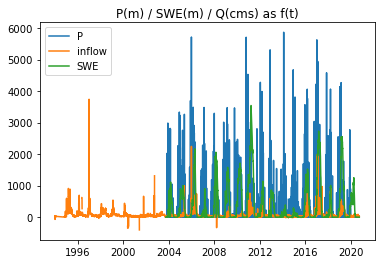

<ipython-input-7-e54726654ff0>:63: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


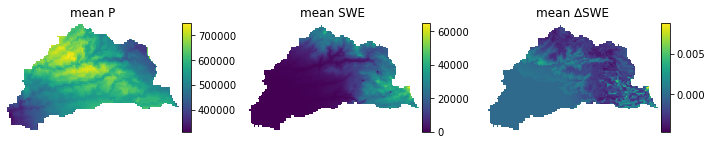

100%|██████████| 4670/4670 [00:11<00:00, 390.00it/s]


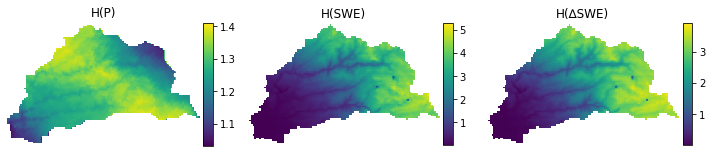

wrote ../rasters/InfoTheory_H_CE_MI_JSD/ENG_p_ent.tif
wrote ../rasters/InfoTheory_H_CE_MI_JSD/ENG_swe_ent.tif
wrote ../rasters/InfoTheory_H_CE_MI_JSD/ENG_dswe_ent.tif


 21%|██        | 1536/7452 [17:57<1:09:14,  1.42it/s]

In [ ]:
for idx, x in enumerate(gdf[:].iterrows()):

    print("****" * 15)
    row  = x[1]
    stn_id = row['stid']
    catch_shp = "../shape/{}.shp".format(stn_id)
    print("Processing res_id: {}, in catchment: {}".format(stn_id, row['catch_name']))

    # Set filepaths
    resfn = os.path.join('../data/res_inflow/{}_res.csv'.format(stn_id))
    swestack_fn = os.path.join('../data/swe/{}_swe.npy'.format(stn_id))
    pstack_fn = os.path.join('../data/prcp/{}_prcp.npy'.format(stn_id))
    
    # Get the daily reservoir inflow
    if not os.path.exists(resfn):
        try:
            inflow = rs.col_to_dt(get_res_data(stn_id, startdate, enddate))
            inflow.to_csv(resfn)
        except:
            print("no data for {}".format(stn_id))
            continue
    else:
        inflow = rs.col_to_dt(pd.read_csv(resfn))
        if len(inflow) == 0:
            print("no data for {}".format(stn_id))
            continue

    # Get the SWE
    if not os.path.exists(swestack_fn):
        swe = get_snodas_swe(catch_shp, startdate, enddate)
        swevals = swe.values()
        swestack = np.dstack(list(swe.values()))
        np.save(swestack_fn, swestack)
    else:
        swestack = np.load(swestack_fn)
        swevals = [swestack[:,:,t] for t in range(0, swestack.shape[2])]
    
    # Calc dSWE in time dim
    dswe = np.diff(swestack, axis = 2)

    # Get the P data
    if not os.path.exists(pstack_fn):
        rsdat = rs.load_data()
        area = rs.gdf_to_ee_poly(gp.read_file(catch_shp))
        pdat = rs.get_daily_ims(rsdat['dmet'], startdate, enddate, area, return_dates = True)
        
        pstack = np.dstack(list(pdat.values()))
        pvals = [pstack[:,:,t] for t in range(0, pstack.shape[2])]
        np.save(pstack_fn, pstack)
    else:
        pstack = np.load(pstack_fn)
        pvals = [pstack[:,:,t] for t in range(0, pstack.shape[2])]
    
    # Sanity check - plot time series sums
    plt.plot(pd.date_range('2003-09-30','2020-10-01', freq='D'), [np.nanmean(x)*1e2 for x in pvals], label = "P")
    plt.plot(inflow.index, inflow.q_cms, label = "inflow")
    plt.plot(pd.date_range('2003-09-30','2020-10-01', freq='D'), [np.nansum(x) for x in swevals], label = 'SWE')
    plt.title("P(m) / SWE(m) / Q(cms) as f(t)")
    plt.legend()
    plt.show()
    
    # Plot annual mean ims 
    pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]
    pmean[pmean == 0] = np.nan
    plot_mean_ims(pmean, swemean, dswemean, stid = stn_id)
        
    # Compute pixelwise entropy
    p_ent = calc_pstack_entropy(pstack)
    p_ent[p_ent==0] = np.nan
    swe_ent = calc_swestack_entropy(swestack, dswe = False)
    swe_ent[swe_ent == 0] = np.nan
    dswe_ent = calc_swestack_entropy(dswe, dswe = True)
    dswe_ent[dswe_ent == 0] = np.nan
    
    plot_ent_ims(p_ent,swe_ent,dswe_ent, stid = stn_id)

    # Setup write dir
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    # Write 
    p_ent_fn = os.path.join(outdir,"{}_p_ent.tif".format(stn_id))
    swe_ent_fn = os.path.join(outdir,"{}_swe_ent.tif".format(stn_id))
    dswe_ent_fn = os.path.join(outdir,"{}_dswe_ent.tif".format(stn_id))

    for im, fn in zip([p_ent, swe_ent, dswe_ent], [p_ent_fn, swe_ent_fn, dswe_ent_fn]):
        rs.write_raster(im, gp.read_file(catch_shp), fn)
        
    # Compute pixelwise js distance, conditional entropy, and mask nans
    p_ce, p_jsd, p_mi = calc_ce_js_mi(pstack, dswe = False)
    swe_ce, swe_jsd, swe_mi = calc_ce_js_mi(swestack, dswe = False)
    dswe_ce, dswe_jsd, dswe_mi = calc_ce_js_mi(dswe, dswe = True)
    
    # Mask nans in precip
    p_jsd = np.ma.masked_array(p_jsd, mask=np.isnan(pmean))
    p_ce = np.ma.masked_array(p_ce, mask=np.isnan(pmean))
    p_mi = np.ma.masked_array(p_mi, mask=np.isnan(pmean))
    
    plot_jsd_ims(p_jsd,swe_jsd,dswe_jsd, stid = stn_id)
    plot_ce_ims(p_ce,swe_ce,dswe_ce, stid = stn_id)
    plot_mi_ims(p_mi,swe_mi,dswe_mi, stid = stn_id)
    
    # Write JSD
    p_jsd_fn = os.path.join(outdir,"{}_p_jsd.tif".format(stn_id))
    swe_jsd_fn = os.path.join(outdir,"{}_swe_jsd.tif".format(stn_id))
    dswe_jsd_fn = os.path.join(outdir,"{}_dswe_jsd.tif".format(stn_id))

    for im, fn in zip([p_jsd, swe_jsd, dswe_jsd], [p_jsd_fn, swe_jsd_fn, dswe_jsd_fn]):
        rs.write_raster(im, gp.read_file(catch_shp), fn)
        
    # Write CE
    p_ce_fn = os.path.join(outdir,"{}_p_ce.tif".format(stn_id))
    swe_ce_fn = os.path.join(outdir,"{}_swe_ce.tif".format(stn_id))
    dswe_ce_fn = os.path.join(outdir,"{}_dswe_ce.tif".format(stn_id))

    for im, fn in zip([p_ce, swe_ce, dswe_ce], [p_ce_fn, swe_ce_fn, dswe_ce_fn]):
        rs.write_raster(im, gp.read_file(catch_shp), fn)
        
    # Write mi
    p_mi_fn = os.path.join(outdir,"{}_p_mi.tif".format(stn_id))
    swe_mi_fn = os.path.join(outdir,"{}_swe_mi.tif".format(stn_id))
    dswe_mi_fn = os.path.join(outdir,"{}_dswe_mi.tif".format(stn_id))

    for im, fn in zip([p_mi, swe_mi, dswe_mi], [p_mi_fn, swe_mi_fn, dswe_mi_fn]):
        rs.write_raster(im, gp.read_file(catch_shp), fn)

In [ ]:
def dict2im(outdict, empty_im):
    outim = np.zeros_like(empty_im)
    outdf = pd.DataFrame.from_dict(outdict)

    # Populate the per-pixel entropy 
    for rc, dfcolidx in zip(rclist,outdf.columns):

        rowidx, colidx = rc
        val = outdf[dfcolidx].values[0]
        outim[rowidx,colidx] = val
        
    return outim


def calc_ce_js_mi(swestack, dswe = False)
    dt_idx = pd.date_range('2003-09-30','2020-10-01', freq='D')

    rows, cols, time = swestack.shape
    px_ts = []
    rclist = []

    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = swestack[row,col,:]
            if not np.isnan(ts_arr).all():

                px_ts.append(pd.Series(ts_arr))
                rclist.append([row,col])

    pxdf = pd.concat(px_ts, axis = 1)
    
    # if time derivative, we have to ditch the first date 
    pxdf.columns = pxdf.columns.map(str)
    if dswe:
        pxdf.index = dt_idx[1:]
    else:
        pxdf.index = dt_idx
    pxdf.columns = pxdf.columns.map(str)

    # Filter infs
    pxdf = pxdf[~pxdf.isin([np.nan, np.inf, -np.inf]).any(1)]

    # Merge w inflow  
    mdf = pd.merge(inflow, pxdf, left_index = True, right_index = True)

    # Drop nans, infs, etc 
    kldf = mdf[mdf['q_cms'].notna()]
    kldf = kldf[~kldf.isin([np.nan, np.inf, -np.inf]).any(1)]
    target = kldf['q_cms']
    kldf.drop(['q_cms'], axis =1 , inplace = True)

    # Build the out image
    outim = np.zeros_like(np.mean(swestack, axis = 2))

    # Setup out dicts to store calcs 
    cond_dict = {}
    js_dict = {}
    mi_dict = {}
    
    # Loop through the cols, calc stuff 
    for pxidx in tqdm(kldf.columns[:]):

        vals = pd.Series(kldf[[pxidx]].values.reshape(kldf[[pxidx]].values.shape[0]))#.value_counts(normalize = True, bins =20)
        vals[~np.isfinite(vals)] = 0
        tempdf = pd.DataFrame([vals,target.values]).T
        tempdf.columns = ['swe','q_cms']
        cond_ent = stats.entropy(tempdf['swe'].value_counts(normalize=True,bins = 1000),tempdf['q_cms'].value_counts(normalize=True,bins = 1000))
        mi = metrics.mutual_info_score(tempdf['swe'].value_counts(normalize=True,bins = 1000),tempdf['q_cms'].value_counts(normalize=True,bins = 1000))
        js_dist = spatial.distance.jensenshannon(tempdf['swe'].value_counts(normalize=True,bins = 1000),tempdf['q_cms'].value_counts(normalize=True,bins = 1000))

        cond_dict[pxidx] = [cond_ent]
        js_dict[pxidx] = [js_dist]
        mi_dict[pxidx] = [mi]
        
    
    cond_ent_im = dict2im(cond_dict, outim)
    cond_ent_im[cond_ent_im == 0] = np.nan
    js_im = dict2im(js_dict, outim)
    js_im[js_im==0] = np.nan
    mi_im = dict2im(mi_dict, outim)
    mi_im[mi_im == 0] = np.nan
    
    return cond_ent_im, js_im, mi_im


In [ ]:
# Loop through the cols, calc stuff 
for pxidx in tqdm(kldf.columns[:200]):

    vals = pd.Series(kldf[[pxidx]].values.reshape(kldf[[pxidx]].values.shape[0]))#.value_counts(normalize = True, bins =20)
    vals[~np.isfinite(vals)] = 0
    tempdf = pd.DataFrame([vals,target.values]).T
    tempdf.columns = ['swe','q_cms']
    cond_ent = stats.entropy(tempdf['swe'].value_counts(normalize=True,bins = 1000),tempdf['q_cms'].value_counts(normalize=True,bins = 1000))
    mi = metrics.mutual_info_score(tempdf['swe'].value_counts(normalize=True,bins = 1000),tempdf['q_cms'].value_counts(normalize=True,bins = 1000))
    js_dist = spatial.distance.jensenshannon(tempdf['swe'].value_counts(normalize=True,bins = 1000),tempdf['q_cms'].value_counts(normalize=True,bins = 1000))

    cond_dict[pxidx] = [cond_ent]
    js_dict[pxidx] = [js_dist]
    mi_dict[pxidx] = [mi]


In [ ]:
def dict2im(outdict, empty_im):
    outim = np.zeros_like(empty_im)
    outdf = pd.DataFrame.from_dict(outdict)

    # Populate the per-pixel entropy 
    for rc, dfcolidx in zip(rclist,outdf.columns):

        rowidx, colidx = rc
        val = outdf[dfcolidx].values[0]
        outim[rowidx,colidx] = val
        
    return outim

In [ ]:
cond_ent_im = dict2im(cond_dict, outim)
cond_ent_im[cond_ent_im == 0] = np.nan
js_im = dict2im(js_dict, outim)
js_im[js_im==0] = np.nan
mi_im = dict2im(mi_dict, outim)
mi_im[mi_im == 0] = np.nan

In [ ]:
plt.imshow(cond_ent_im)
plt.colorbar()
plt.show()
plt.imshow(js_im)
plt.colorbar()
plt.show()
plt.imshow(mi_im)
plt.colorbar()
plt.show()

In [ ]:
kldf.sample(20, axis = 1).plot()

In [ ]:
outim[outim==0] = np.nan
plt.imshow(outim)
plt.colorbar()

In [ ]:
dt_idx = pd.date_range('2003-09-30','2020-10-01', freq='D')

rows, cols, time = pstack.shape
px_ts = []
rclist = []

# extract pixelwise timeseries
for row in tqdm(range(rows)):
    for col in range(cols):
        ts_arr = pstack[row,col,:]
        if not np.isnan(ts_arr).all():

            px_ts.append(pd.Series(ts_arr))
            rclist.append([row,col])

pxdf = pd.concat(px_ts, axis = 1)


In [ ]:
# if time derivative, we have to ditch the first date 
pxdf.columns = pxdf.columns.map(str)
if False:
    pxdf.index = dt_idx[1:]
else:
    pxdf.index = dt_idx
pxdf.columns = pxdf.columns.map(str)

In [ ]:
pxdf

In [ ]:
import time
start = time.time()


pxdf = pd.DataFrame(px_ts).T
# if time derivative, we have to ditch the first date 
pxdf.columns = pxdf.columns.map(str)
if dswe:
    pxdf.index = dt_idx[1:]
else:
    pxdf.index = dt_idx
pxdf.columns = pxdf.columns.map(str)


"the code you want to test stays here"
end = time.time()
print(end - start)

In [ ]:
now = time.time()
time.sleep(10)
print(now - time.time())

In [ ]:
# Build the out image
outim = np.zeros_like(np.mean(pstack, axis = 2))

# Compute and compile the stats
outict = {}

# Loop through the cols, calc entropy
for pxidx,array in tqdm(enumerate(px_ts)):

    vals = pd.Series(array).value_counts(normalize=True)
    outict[pxidx] = [stats.entropy(vals)]

outdf = pd.DataFrame.from_dict(outict)

In [ ]:
# Populate the per-pixel entropy 
for rc, dfcolidx in zip(rclist,outdf.columns):

    rowidx, colidx = rc
    val = outdf[dfcolidx].values[0]
    outim[rowidx,colidx] = val

In [ ]:
plt.imshow(outim)
plt.colorbar()

In [ ]:
    outict = {}

    # Loop through the cols, calc entropy
    for pxidx in tqdm(pxdf.columns[:]):

        vals = pd.Series(pxdf[[pxidx]].values.reshape(pxdf[[pxidx]].values.shape[0])).value_counts(normalize=True)
        outict[pxidx] = [stats.entropy(vals)]

    outdf = pd.DataFrame.from_dict(outict)

In [ ]:
# Clip the rasters to the watershed boundaries 

for idx, x in enumerate(gdf[:].iterrows()):
    print(idx)
    print("****" * 15)

    row  = x[1]
    stn_id = row['stid']
    print(stn_id, row['catch_name'])
    
    # Setup dirs 
    tefn = os.path.join(outdir,"{}_TE.tif".format(stn_id))
    swefn = os.path.join(outdir,"{}_swe.tif".format(stn_id))    
    
    # Clip rasters to shp 
    catch_shp = "../shape/{}.shp".format(stn_id)
    
    for fn in [lagfn,corfn,swefn]:
        outfn = fn[:-4] + "_cl.tif"
        cmd = '''gdalwarp -cutline {} -crop_to_cutline -dstalpha {} {}'''.format(catch_shp, fn, outfn)
        print(cmd)
        os.system(cmd) 